# Datascience project
## Goal :
The goal of this project is to create graph of characters from transcripts of popular Tv shows from https://transcripts.foreverdreaming.org.
Theses graph will be merge per seasons and compared to the others graph in order to find correlations with their caracteristics.

## How will it works ?
First, we will get the data : we will download the transcripts for each tv show and store it into HTML files. Next, we will analyze each of them and generate one graph per episode and merge theses graphs to get a graph for each season. We will finally compare all the graphs with their caracteristics and try to find some characters pattern.

## Get the data :
So we will request https://transcripts.foreverdreaming.org and get the links of the tv shows :

In [1]:
import os
import sys
from bs4 import BeautifulSoup
import requests
import pickle
import os
import time
import re
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#Global variables
urlWebsite = "https://transcripts.foreverdreaming.org";
#We will define a fake agent to contourn the protection
agent = {"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'}
#Interval between two http requests :
interval = 1;

#Important functions :

#Return the soup of the link
def get_soup(url):
    print(get_now_datetime_str() + " -> request : " + url);
    agent = {"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'}
    page = requests.get(url, headers=agent)
    soup = BeautifulSoup(page.content)
    return soup;

#Return the soup of a local file
def get_moms_soup(path):
    print(get_now_datetime_str() + " -> file : " + path);
    page = BeautifulSoup(open(path, encoding='utf8'), "html.parser", from_encoding="utf-8")
    return page;


#Initialize a void pickle
def init_pickle(path):
    write_pickle(path, []);

#Write a pickle
def write_pickle(path, array_pickle):
    pickle_out = open(path,"wb");
    pickle.dump(array_pickle, pickle_out);
    pickle_out.close();

#Read a pickle
def read_pickle(path, type_data="list"):
    file_path = Path(path);
    if(file_path.exists()):
        pickle_in = open(path,"rb");
        data = pickle.load(pickle_in);
        pickle_in.close();
        return data;
    else:
        if(type_data == "dict"):
            return {};
        return [];
    
#Clean a string
def clean_str(dirty_str):
    cleaned_str = dirty_str.rstrip().lstrip();
    return re.sub('[^a-zA-Z0-9 \n\.]', "", cleaned_str);
    

#Find the next page or return False if there is no next page
def find_next_page(soup):
    pagination = soup.findAll('b', attrs={'class':'pagination'})
    if(len(pagination) == 0):
        return False;
    other_pages = pagination[0].findAll('a')
    for page in other_pages:
        if(page.getText() == "»"):
            return page.get('href');
    return False;

#Transform the soup into a list of link to episode transcript
def html_to_url_list_episode(soup):
    link_list = [];
    flag_info = False #True if the rows of info are passed.
    table = soup.findAll('table', attrs={'class' : 'tablebg'});
    rows = table[0].findAll('tr');
    for row in rows:
        if(not(flag_info)):
            row_episode = row.findAll('b', attrs={'class' : 'gensmall'});
            if(len(row_episode) != 0 and row_episode[0].getText() == "Episode"):
                flag_info = True;
        else:
            line = row.findAll('a')[0];
            row_link = urlWebsite + line.get('href')[1:];
            name =  clean_str(line.getText());
            row_name = name;
            link_list.append([row_name, row_link]);
    return link_list;

#Return a string containing the current time
def get_now_datetime_str():
    now = datetime.now();
    return now.strftime("%H:%M:%S");

#make a dir if not exist
def mk_dir_ifn_exist(path):
    if not os.path.exists(path):
        os.mkdir(path);
   
    
#Loop the requesting of the page until it succeed
def req_until_death(url):
    time.sleep(interval);
    agent = {"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'};
    request_done = False;
    while(not(request_done)):
        try:
            print(get_now_datetime_str() + " -> request : " + url);
            page = requests.get(url, headers=agent, timeout=10);
            if(type(page) == "ReadTimeout" ):
                continue;
            else:
                request_done = True;
                soup = BeautifulSoup(page.content);
            return soup;
        except requests.exceptions.RequestException as e:
            print(get_now_datetime_str() + " -> failure, retry !");
            time.sleep(60);

In [ ]:
#Create important folders
mk_dir_ifn_exist("img");
mk_dir_ifn_exist("data");
mk_dir_ifn_exist("pickle");
mk_dir_ifn_exist("pickle/series");
mk_dir_ifn_exist("pickle/graphs");

### Step 1 : Get the index of all the tv shows
WARNING : Do not execute the following code if you already have the following files : 
- pickle/tv_shows.pickle
- pickle/tv_show_list.pickle 
- pickle/list_made.pickle !

In [ ]:
#Let's make our soup
soup = req_until_death(urlWebsite);

In [ ]:
#Now, we have to find all the <a> link with the css class "subforum"
tv_shows = {};
tv_shows_list = [];
for link in soup.findAll('a', attrs={"class" : "subforum"}):
    name =  clean_str(link.getText());
    tv_shows[name] = urlWebsite + link.get('href')[1:];
    tv_shows_list.append(name);

In [ ]:
write_pickle("pickle/tv_shows.pickle", tv_shows); #Contain a dict with the tv show and their link to the index of their transcript
write_pickle("pickle/tv_shows_list.pickle", tv_shows_list); #Contain a list of the tv_show

for name in tv_shows_list:
    if not os.path.exists("data/" + name):
        os.mkdir("data/" + name);
    if not os.path.exists("pickle/" + name):
        os.mkdir("pickle/" + name);

END OF THE WARNING  
Let's load the list of our tv shows and the dict that contains the link to the transcript's listing pages :

### Step 2 : Create the index
Now, we will create an index per tv show, each containing all the links to all his episodes !

In [ ]:
tv_shows = read_pickle("pickle/tv_shows.pickle");
tv_shows_list = read_pickle("pickle/tv_shows_list.pickle");
list_series_already_indexed = read_pickle("pickle/list_series_already_indexed.pickle")

In [ ]:
for serie in tv_shows_list:
    print(get_now_datetime_str() + " : " + serie)
    if(serie in list_series_already_indexed and read_pickle("pickle/" + serie + "/episode_list.pickle") != []):
        continue;
        
    else:
        url = tv_shows[serie];
        all_episode = [];
        next_page_exist = True;
        while(next_page_exist): #If there is another index page, get it !
            soup = req_until_death(url);
            next_page = find_next_page(soup);
            if(next_page == False):
                next_page_exist = False;
            else:
                url = urlWebsite + next_page[1:];
            all_episode = all_episode + html_to_url_list_episode(soup);
            
        write_pickle("pickle/" + serie + "/episode_list.pickle", all_episode);
        
    list_series_already_indexed.append(serie);
    write_pickle("pickle/list_series_already_indexed.pickle", list_series_already_indexed);

### Step 3 : Download transcripts
Now, we will download all the transcript, it will have an HTML format.

In [ ]:
def dl_transcript_page(soup, name, path):
    body = soup.findAll('div', attrs={'class':'postbody'})[0]
    final_path = path + "/" + name + ".html";
    with open(final_path, "w", encoding="utf-8") as file:
        file.write(body.prettify())

Rewrite the pickle file "already dl" for each serie based on the HTML files saved in case where the pickle save had an error

In [ ]:
for serie in tv_shows_list:
    print(get_now_datetime_str() + " : " + serie);
    episodes = read_pickle("pickle/" + serie + "/episode_list.pickle");
    episode_already_dl = [];
    for episode in episodes:
        name = episode[0];
        path = "data/" + serie + "/" + name + ".html";
        file_path = Path(path);
        if(file_path.exists()):
            print(get_now_datetime_str() + " -> OK for : " + name);
            episode_already_dl.append(episode[0])
            write_pickle("pickle/" + serie + "/episode_already_dl.pickle",episode_already_dl);

Download each HTML file containing the transcript of the episode.

In [ ]:
for serie in tv_shows_list:
    print(get_now_datetime_str() + " : " + serie);
    episodes = read_pickle("pickle/" + serie + "/episode_list.pickle");
    episode_already_dl = read_pickle("pickle/" + serie + "/episode_already_dl.pickle");
    
    for episode in episodes:
        if(episode[0] in episode_already_dl):
            continue;
        
        episode_already_dl.append(episode[0])
        name = episode[0];
        url = episode[1];
        print(get_now_datetime_str() + " -> Reading : " + episode[0]);
        soup = req_until_death(url);
        dl_transcript_page(soup, name, "data/" + serie);
        write_pickle("pickle/" + serie + "/episode_already_dl.pickle",episode_already_dl);

### Step 4 : Building our data
First we will extract the name of the characters and building their relations. Next, we will clean our data by excluding the outliers (that are probably false positive result of the character detection). We will build our graph and take some metrics to compare them.

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

Extract characters and relations from the html :

In [ ]:
#clean a string
def clean_string(string_to_clean):
    string_to_clean = string_to_clean.replace('\n', ' ');
    string_to_clean = string_to_clean.strip();
    string_to_clean = string_to_clean.lstrip();
    string_to_clean = string_to_clean.rstrip();
    return string_to_clean;

#Return all the words identified as name of a character
def id_characters(sentence):
    name_list = [];
    doc = nlp(sentence)
    for ent in doc.ents:
        if(ent.label_ == "PERSON"): #Get all the words identified as character's name
            name = ent.text.lower();
            name_list.append(clean_string(name));
    return name_list;
    
#Extract characters and their relations from an html file
def extract_charac_of_episode(file_path):
    soup = get_moms_soup(file_path);
    lines_html = soup.findAll("p");
    characters_list = {};
    relations_list = [];
    
    for dirty_line in lines_html:
        line = dirty_line.get_text();
        line = clean_string(line);
        characs = id_characters(line);
        
        for i in range(0, len(characs)):
            #Create or increase the weight of the characters
            if(not(characs[i] in characters_list)):
                characters_list[characs[i]] = 1;
            else:
                characters_list[characs[i]] = characters_list[characs[i]] + 1;
        
            if(i+1 != len(characs)):
                for j in range(i+1, len(characs)):
                    next_charac = False; #The current character is the last one detected
                else:
                    next_charac = characs[i+1];
                relation_found = False;
                #Create or increase the weight of the relations
                for x in range(0, len(relations_list)):
                    if((characs[i] == relations_list[x][0] and next_charac == relations_list[x][1]) or (characs[i] == relations_list[x][1] and next_charac == relations_list[x][0])):
                        relation_found = True;
                        relations_list[x][2] = relations_list[x][2] + 1;
                        break;
                if(not(relation_found)):
                    relations_list.append([characs[i], next_charac, 1])
                    
    return characters_list, relations_list;

def merge_characs_serie(final_array, add_array):
    for charac in add_array:
        if(not(charac in final_array)):
            final_array[charac] = 1;
        else:
            final_array[charac] = final_array[charac] + add_array[charac];
        
    return final_array;

def merge_relations_serie(final_array, add_array):
    for relation in add_array:
        charac_1 = relation[0];
        charac_2 = relation[1];
        weight = relation[2];
        
        relation_found = False;
        for i in range(0, len(final_array)):
            final_relation = final_array[i];
            if((charac_1 == final_relation[1] and charac_2 == final_relation[0]) or charac_1 == final_relation[0] and charac_2 == final_relation[1]):
                final_array[i][2] = final_array[i][2] + weight;
                relation_found = True;
                break;
        
        if(not(relation_found)):
            final_array.append([charac_1, charac_2, weight]);
            
    return final_array;

#Extract all the characters and their relations from a serie (each episode one by one and merge the results)
def extract_charac_of_serie(serie):
    print(get_now_datetime_str() + " -> extract begin : " + serie);
    list_episodes = read_pickle('pickle/' + serie + "/episode_already_dl.pickle");
    final_characters = {};
    final_relations = [];
    
    for episode in list_episodes:
        path_episode = "data/" + serie + "/" + episode + '.html';
        temp_chara, temp_rela = extract_charac_of_episode(path_episode);
        final_characters = merge_characs_serie(final_characters, temp_chara);
        final_relations = merge_relations_serie(final_relations, temp_rela);
    
    print(get_now_datetime_str() + " -> extract end");
    return final_characters, final_relations;
        
    

In [ ]:
#Extract the characters and their relations from each tv show
series = read_pickle('pickle/list_series_already_indexed.pickle')
for serie in series:
    if(read_pickle('pickle/' + serie + '/relations.pickle') != [] or read_pickle('pickle/' + serie + '/characters.pickle') != []):
        continue;
        
    characters, relations = extract_charac_of_serie(serie);
    write_pickle('pickle/' + serie + '/characters.pickle', characters);
    write_pickle('pickle/' + serie + '/relations.pickle', relations);

Now, we have our basic data, we have to clean them by remove the lowest outliers. Not the highest because they are probably the main characters.
We will also remove the characters only mentionned one time and their relations because they are probably errors.

In [ ]:
def relation_per_characters(relations, characters):
    count_relation_per_charac = {};
    for name in characters:
        count_relation_per_charac[name] = 0;

    for relation in relations:
        name_1 = None;
        name_2 = None;
        if(relation[0] in characters):
            name_1 = relation[0];
        if(relation[1] in characters):
            name_2 = relation[1];

        if(not(name_1 == None) and not(name_2 == None)):
                count_relation_per_charac[name_1] = count_relation_per_charac[name_1] + 1;
                count_relation_per_charac[name_2] = count_relation_per_charac[name_2] + 1;
    
    return count_relation_per_charac;
    
def clean_relations(dirty_relations, characters):
    cleaned_relations = [];
    for relation in dirty_relations:
        if(relation[0] in characters and relation[1] in characters):
            cleaned_relations.append(relation);
    return cleaned_relations;

def suppress_no_edge(characters, relations):
    count_relation_per_charac = relation_per_characters(relations, characters);
    new_characters = {};
    for charac in characters:
        if(count_relation_per_charac[charac]  > 0):
            new_characters[charac] = characters[charac];
    return new_characters;

def suppress_one_and_less_occurence(characters):
    new_characters = {};
    for charac in characters:
         if(characters[charac] > 1):
            new_characters[charac] = characters[charac];
    return new_characters;

def keep_only_main_characters(characters):
    if(characters != {}):
        weights_characs = [];
        for charac in characters:
            weights_characs.append(characters[charac]);
        sorted(weights_characs);

        q1, q3= np.percentile(weights_characs,[25,75]);
        iqr = q3 - q1;
        lower_bound = q3 + iqr;
        new_characs = {};
        for charac in characters:
            if(not(characters[charac] < lower_bound)):
                new_characs[charac] = characters[charac];
        characters = new_characs;
    return characters

def merge_same_characters(characters, relations):
    replaced_names = [];
    while(True):
        replaced_character = False;

        for name in characters:
            for new_name in characters:
                if((name in new_name) and (len(name) < len(new_name)) and (not(name in replaced_names))): #If one of the two name contain the other and is bigger
                    replaced_character = True;
                    weight = characters[new_name] + characters[name];
                    characters[new_name] = weight;
                    replaced_names.append(name);

                    #TODO : Replace relations by a Hashmap based on the names of the two characters
                    for relation in relations:  #Update the names in the relations
                        if(relation[0] == name):
                            relation[0] = new_name;
                        if(relation[1] == name):
                            relation[1] = new_name;

        if(not(replaced_character)):
            break;

    for name in replaced_names:   
        del characters[name];
        
    return characters, relations;

def remove_relations_between_same_character(relations):
    relations_new = [];
    for relation in relations:
        if(relation[0] != relation[1]):
            relations_new.append(relation);
    return relations_new;

In [ ]:
def clean_data(serie):
    print(get_now_datetime_str() + " -> cleaning : " + serie);
    relations = read_pickle('pickle/' + serie + '/relations.pickle');
    characters = read_pickle('pickle/' + serie + '/characters.pickle');
    
    if(characters != {}):
        #Check and replace if you found a more longest is declared for the same character
        characters, relations = merge_same_characters(characters, relations);
        relations = remove_relations_between_same_character(relations);
            
        #We suppress the nodes without any occurence or just one and the nodes without any edge
        characters = suppress_one_and_less_occurence(characters);
        relations = clean_relations(relations, characters);
        characters = suppress_no_edge(characters, relations);
        
        #Now, we remove all the characters that cannot be considered as primary using Q3 + IQR :
        characters = keep_only_main_characters(characters);
        relations = clean_relations(relations, characters);
        characters = suppress_no_edge(characters, relations);
                    
    write_pickle('pickle/' + serie + '/characters_cleaned.pickle', characters);
    write_pickle('pickle/' + serie + '/relations_cleaned.pickle', relations);
    return characters, relations;

In [ ]:
series = read_pickle('pickle/list_series_already_indexed.pickle')
for serie in series:
    if(read_pickle('pickle/' + serie + '/relations.pickle') == [] and read_pickle('pickle/' + serie + '/characters.pickle') == []):
        continue;
    characs, relations = clean_data(serie);

So, we now will create our graphs, one per serie :

In [ ]:
series = read_pickle('pickle/list_series_already_indexed.pickle')
graphs_complete = [];
for serie in series:    
    graph_serie = nx.Graph();
    relations = read_pickle('pickle/' + serie + '/relations_cleaned.pickle');
    characters = read_pickle('pickle/' + serie + '/characters_cleaned.pickle');
    if(len(characters) != 0):
        for character in characters:
            graph_serie.add_node(character, weight=characters[character]);
        for relation in relations:
            graph_serie.add_edge(relation[0], relation[1], weight=relation[2]);
        write_pickle('pickle/' + serie + '/graph.pickle', graph_serie)
        if not(serie in graphs_complete):
            graphs_complete.append(serie); #allow us to remove the series where we don't find any characters after our filters

write_pickle('pickle/graph_serie.pickle', graphs_complete);
    

Now, we will analyze theses graph as if they was social network graph. In this case, the main metrics are metrics of connections, distributions and segmentations :
- Connections :
    - Homophily (assortativity)
    - Multiplexity (average degree of connectivity)
    - Network Closure (transivitive closure)
- Distributions :
    - Centrality (degree, closeness, etc.)
    - Density
    - Structural holes
- Segmentation
    - Clustering coefficient
    - Cohesion
    
So, we will first save our graph in picture and next analyze their caracteristics.  
In addition to this, we will get the genre of each serie on IMDB and its rate.

In [ ]:
def avg_dict(dict_to_avg):
    dict_total = 0;
    for key in dict_to_avg:
        dict_total = dict_total + dict_to_avg[key];
    return (dict_total  / len(dict_to_avg));

def min_dict(dict_to_min):
    min_val = None;
    for key in dict_to_min:
        val = dict_to_min[key];
        if(min_val == None):
            min_val = val;
        elif(val < min_val):
            min_val = val;
    return min_val;
    
def max_dict(dict_to_max):
    max_val = None;
    for key in dict_to_max:
        val = dict_to_max[key];
        if(max_val == None):
            max_val = val;
        elif(val > max_val):
            max_val = val;
    return max_val;

In [ ]:
series = read_pickle('pickle/graph_serie.pickle') #Now, we will only use the list of the tv show we created a graph with
for serie in series:
    print(get_now_datetime_str() + " -> graph compute : " + serie);
    G = read_pickle('pickle/' + serie + '/graph.pickle')
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111)
    ax.set_title(serie, fontsize=10)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=1500, node_color='black', font_size=8, font_weight='bold')

    plt.tight_layout()
    plt.savefig("./img/graph_" + serie + ".png", format="PNG")
    plt.close();

In [ ]:
series = read_pickle('pickle/graph_serie.pickle');
series_carac = {};
for serie in series:
    print(get_now_datetime_str() + " -> graph compute : " + serie);
    graph = read_pickle('pickle/' + serie + '/graph.pickle')
    graph_caracs = {};
    
    #Computation of thebetweeness of the graph
    betweeness = nx.betweenness_centrality(graph, weight='weight');
    graph_caracs['avg_betweeness'] = avg_dict(betweeness);
    graph_caracs['min_betweeness'] = min_dict(betweeness);
    graph_caracs['max_betweeness'] = max_dict(betweeness);
    #Computation of the degree of connectity of the graph's nodes
    deg_connect = nx.average_degree_connectivity(graph, weight='weight');
    graph_caracs['avg_deg_connect'] = avg_dict(deg_connect);
    graph_caracs['min_deg_connect'] = min_dict(deg_connect);
    graph_caracs['max_deg_connect'] = max_dict(deg_connect);
    #Computation of the degree centrality of the nodes of the graph
    cent_degree = nx.degree_centrality(graph);
    graph_caracs["avg_centrality_degree"] = avg_dict(cent_degree);
    graph_caracs["min_centrality_degree"] = min_dict(cent_degree);
    graph_caracs["max_centrality_degree"] = max_dict(cent_degree);
    #Computation of the centrality closeness
    cent_close = nx.closeness_centrality(graph);
    graph_caracs["avg_centrality_closeness"] = avg_dict(cent_close);
    graph_caracs["min_centrality_closeness"] = min_dict(cent_close);
    graph_caracs["max_centrality_closeness"] = max_dict(cent_close
    #Computation of the graph density
    graph_caracs["density"] = nx.density(graph);
    #Computation of the structure hole of the nodes
    struct_hole = nx.constraint(graph, weight="weight");
    graph_caracs["avg_struct_holes"] = avg_dict(struct_hole);
    graph_caracs["min_struct_holes"] = min_dict(struct_hole);
    graph_caracs["max_struct_holes"] = max_dict(struct_hole);
    #Computation of the clustering coeff
    clus_coef = nx.clustering(graph, weight='weight');
    graph_caracs["avg_clus_coef"] = nx.average_clustering(graph, weight='weight');
    graph_caracs["min_clus_coef"] = min_dict(clus_coef);
    graph_caracs["max_clus_coef"] = max_dict(clus_coef);
    
    write_pickle('pickle/' + serie + '/graph_caracs.pickle', graph_caracs);
    series_carac[serie] = graph_caracs;
    
write_pickle('pickle/all_graph_caracs.pickle', series_carac);
    

Now that we have all the caracteristics of our graphs, we will collect some additionnal informations about them. So we will use IMDB to collect the genre and the rate of each tv show !

In [6]:
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [ ]:
series = read_pickle('pickle/graph_serie.pickle');
imdb_info = {};
url_site = "https://www.imdb.com";

categories_per_show = read_pickle('pickle/metadata_per_show.pickle', 'dict');
    
for serie in series:
    print(get_now_datetime_str() + " -> Searching for : " + serie);
    if(serie in categories_per_show):
        continue;
    name_serie_url = serie.replace(' ', '+')
    url = "https://www.imdb.com/search/title/?title=" + name_serie_url + "&title_type=tv_series" #We use the edvanced research of the website.
    
    genres = None;
    rate = None;
    
    soup = get_soup(url);
    box = soup.findAll("div", {"class":"lister-item-content"});
    if(len(box) == 0): #If no result with the advanced research, we use the general research and take the first film returned.
        print(get_now_datetime_str() + " -> No result, I will use the alternative research...");
        url = "https://www.imdb.com/find?ref_=nv_sr_fn&q=" + name_serie_url + "&s=all"
        soup = get_soup(url);
        box = None;
        
        for result_list in soup.findAll('div', {"class" : "findSection"}):
            title = result_list.findAll('h3')[0]
            if("Titles" in title.text):
                box = result_list.findAll("td", {"class":"result_text"})[0];
                    
        link = box.findAll("a")[0]['href'];
        
        soup = get_soup(url_site + link);
        sub_box = soup.findAll("div", {"class" : "subtext"})[0];
        links = sub_box.findAll("href");
        for link in links:
            href = link['href'];
            if("genre" in href):
                genre.append(clean_str(link.text));
                
        rate_soup = soup.findAll('span', {'itemprop': 'ratingValue'});
        if(len(rate_soup) == 0):
            rate = None;
        else:
            rate = clean_str(rate_soup[0].text);
        
    else:
        box = box[0];
        genres = [];
        genres_brut = (box.findAll("span", {"class" : "genre"})[0].text).split(", ");
        for genre in genres_brut:
            genres.append(clean_str(genre));
        rate = clean_str(box.findAll("strong")[0].text);

    categories_per_show[serie] = {};
    categories_per_show[serie]["rate"] = rate;
    categories_per_show[serie]["genres"] = genres;
    write_pickle('pickle/metadata_per_show.pickle', categories_per_show);
print(categories_per_show)

Now, we will join the tv show with their genres. In order to simplify our classfifier, for one tv show with multiple genres, we will make multiple tv show similar with one different genre each.

In [8]:
series = read_pickle('pickle/graph_serie.pickle');
categories_per_show = read_pickle('pickle/metadata_per_show.pickle', 'dict');
database_tv_show = [];
tv_show_in_database = []

for serie in series:
    graph_caracs = read_pickle('pickle/' + serie + '/graph_caracs.pickle');
    if(categories_per_show[serie]['genres'] == None or categories_per_show[serie]['rate'] == None):
        continue;
    genres = categories_per_show[serie]['genres'];
    new_row = {};
    
    new_row["name"] = serie;
    new_row['rate'] = categories_per_show[serie]['rate'];
    
    for carac in graph_caracs:
        new_row[carac] = graph_caracs[carac];
    
    new_database = [];
    
    for genre in genres:
        final_new_row = {}
        final_new_row["genre"] = genre;
        for carac in new_row:
            final_new_row[carac] = new_row[carac]
        new_database.append(final_new_row);
        
    database_tv_show = database_tv_show + new_database;
    
write_pickle('pickle/tv_show_in_database.pickle', tv_show_in_database);
write_pickle('pickle/database_tv_show.pickle', database_tv_show);

In [9]:
database_array = read_pickle('pickle/database_tv_show.pickle');
database_df = pd.DataFrame.from_dict(database_array, orient='columns')

In [10]:
list_genre = [];
for genre in database_df['genre']:
    if(not(genre in list_genre)):
        list_genre.append(genre);
print(list_genre);

['Adventure', 'Drama', 'Mystery', 'Comedy', 'Action', 'Biography', 'Crime', 'Horror', 'Thriller', 'Music', 'Romance', 'Family', 'SciFi', 'History', 'Animation', 'Fantasy', 'TalkShow', 'War']


Next, we will see which values we could remove to simplify our classifier.

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


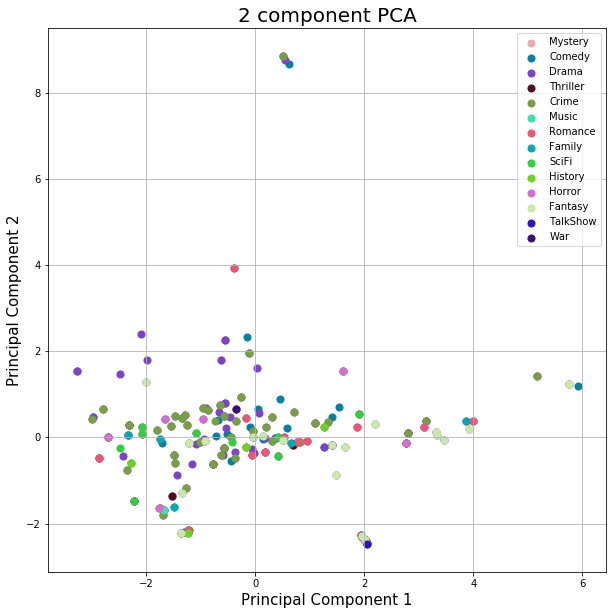

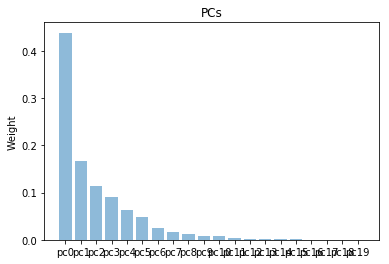


#########################################

SCORES :

#########################################

     avg_betweeness  avg_centrality_closeness  avg_centrality_degree  \
pc0        0.093803                  0.320451               0.335518   
pc1       -0.351364                  0.181571               0.085199   

     avg_clus_coef  avg_deg_connect  avg_struct_holes   density  \
pc0       0.172661        -0.175920          0.263327  0.335518   
pc1      -0.059151         0.366485         -0.209314  0.085199   

     max_betweeness  max_centrality_closeness  max_centrality_degree  \
pc0       -0.016799                  0.246232               0.249626   
pc1       -0.348185                  0.246309               0.241132   

     max_clus_coef  max_deg_connect  max_struct_holes  min_betweeness  \
pc0       0.096217        -0.168077          0.047082    7.703720e-34   
pc1      -0.182651         0.348655         -0.276163    0.000000e+00   

     min_centrality_closeness  min_centrality_d

In [10]:
df  = database_df.drop(['genre', 'name'], axis=1)
score2 = StandardScaler().fit_transform(df)

pca = PCA()
principalComponents = pca.fit_transform(score2)

pca_list = [];
for i in range(0, len(df.columns)):
    pca_list.append("pc" + str(i));

principalDf = pd.DataFrame(data = principalComponents, columns = pca_list)
finalDf = pd.concat([principalDf, database_df[['genre']]], axis = 1)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

genres = ['Mystery', 'Comedy', 'Drama', 'Thriller', 'Crime', 'Music', 'Romance', 'Family', 'SciFi', 'History', 'Horror', 'Fantasy', 'TalkShow', 'War']
colors = [];
for genre in genres:
    colors.append(np.random.rand(3,1))


for genre, color in zip(genres, colors):
    indicesToKeep = finalDf['genre'] == genre
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color.ravel()
               , s = 50)
ax.legend(genres)
ax.grid()
plt.show()

y_pos = np.arange(len(pca_list))
performance = [10,8,6,4,2,1]

plt.bar(y_pos, pca.explained_variance_ratio_, align='center', alpha=0.5)
plt.xticks(y_pos, pca_list)
plt.ylabel('Weight')
plt.title('PCs')

plt.show()

score_df=  pd.DataFrame(pca.components_,columns=df.columns,index = pca_list)[:2]
print('\n#########################################\n')
print("SCORES :")
print('\n#########################################\n')
print (score_df)

columns_to_keep = [];
column_score = {};
for column in score_df:
    pc1_value = score_df[column][0];
    pc2_value = score_df[column][1];
    if(pc1_value < 0):
        pc1_value = pc1_value*-1;
    if(pc2_value < 0):
        pc2_value = pc2_value*-1;
        
    column_score[column] = pc2_value + pc1_value;
    
    if((score_df[column][0] < -0.3 or score_df[column][0] > 0.3) or (score_df[column][1] > 0.3 or score_df[column][1] < -0.3)):
        columns_to_keep.append(column)
        
print(column_score)
print('\n#########################################\n')
print("COLUMNS TO KEEP : ")
print('\n#########################################\n')
print(columns_to_keep);

So, as we can see on the bar chart, the main data are contained in the first two components. The columns that influe the most on these data are (We only keep the column with more than 0.3 of score) :
- For PC0 :
    - Average centrality closeness
    - Average centrality degree
    - Density
    - Min centrality closeness
    - Min centrality degree
    - Min structure holes

- For PC1 :
    - Average betweeness
    - Average degree of connection
    - Max betweeness
    - Max degree of connection
    - Min degree of connection


In [12]:
database_df = database_df[columns_to_keep + ['genre', 'name']]
write_pickle('pickle/new_database.pickle', database_df);

Now, we will use a logistic regression as a classifier :

In [3]:
import random 
from sklearn.linear_model import LogisticRegression
import collections;

def partition (list_in, n):
    perc = int(n*len(list_in))
    random.shuffle(list_in)
    test_list = [];
    train_list = [];
    for i in range(0, perc):
        test_list.append(list_in[i]);
    for i in range(perc, len(list_in)):
        train_list.append(list_in[i]);
    return test_list, train_list

def detect_error(test_list, test_result, database, clf):
    database_df = read_pickle('pickle/new_database.pickle');
    results = [];
    no_predicted = {};
    total_genres = {};
    for index, test in test_list.iterrows():
        
        y_predicted = clf.predict_proba(test_list.loc[[index]]);
        name = test_result.loc[[index]]['name'].values[0]
        genres = database_df['genre'].loc[database_df['name'] == name].tolist()
        
        class_for_proba = dict(zip(clf.classes_, y_predicted[0]));
        most_proba_genres = sorted(class_for_proba, key=class_for_proba.get, reverse=True)[:len(genres)]
        
        good_answer = 0;
        for genre in genres:
            if(genre in most_proba_genres):
                good_answer = good_answer + 1;
            else:
                if(genre in no_predicted):
                    no_predicted[genre] = no_predicted[genre] + 1;
                else:
                    no_predicted[genre] = 1;
                    
            if(not(genre in total_genres)):
                total_genres[genre] = 1;
            else:
                total_genres[genre] = total_genres[genre] + 1;
                
        results.append(good_answer/len(genres) * 100);
    
    perc_result = np.mean(results);
    no_predicted = dict(sorted(no_predicted.items(), key=lambda kv: kv[1], reverse=True))
    return perc_result, no_predicted, total_genres;


In [4]:
def run_test(train_size):
    database_df = read_pickle('pickle/new_database.pickle');
    series = read_pickle('pickle/graph_serie.pickle');
    part_test, part_train = partition(series, train_size);

    y = database_df[['genre', 'name']];
    x = database_df.drop(['genre', 'name'], axis=1);

    train = database_df[database_df['name'].isin(part_train)]
    test = database_df[database_df['name'].isin(part_test)]

    x_train = train.drop(['genre', 'name'], axis=1);
    x_test =  test.drop(['genre', 'name'], axis=1);
    y_train =  train[['genre', 'name']]
    y_test =  test[['genre', 'name']];

    clf = LogisticRegression(max_iter=5000, random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, y_train['genre'])

    test_result, no_pred, total_genre = detect_error(x_test, y_test, database_df, clf)
    return test_result, no_pred, total_genre, clf, test, train;

A little test to see the impact of the split of the data into training and test dataset will impact our results

In [8]:
if(len(read_pickle('pickle/size_train_test_results.pickle')) != 0):
    train_size_list, results_for_train_size = read_pickle('pickle/size_train_test_results.pickle')
else:
    train_size_list = [];
    results_for_train_size = [];
    
for i in range(5, 100, 5):
    train_size = i/100;
    if(train_size in train_size_list):
        continue;
    else:
        print(get_now_datetime_str() + " -> Test for train size = " + str(train_size));
    run_test_results = [];
    nb_iter = 200
    for j in range(0, nb_iter):
        result_score, _ , _ ,_, _, _= run_test(train_size);
        run_test_results.append(result_score);
        
    results_for_train_size.append(np.mean(run_test_results));
    train_size_list.append(train_size);
    write_pickle('pickle/size_train_test_results.pickle', [train_size_list, results_for_train_size])
    print(get_now_datetime_str() + " -> Average success = " + str(np.mean(run_test_results)));
    
write_pickle('pickle/size_train_test_results.pickle', [train_size_list, results_for_train_size])

17:42:34 -> Test for train size = 0.05
17:46:00 -> Average success = 50.837997229864406
17:46:00 -> Test for train size = 0.1
17:49:58 -> Average success = 50.48593510402612
17:49:58 -> Test for train size = 0.15
17:53:45 -> Average success = 50.33389852373257
17:53:45 -> Test for train size = 0.2
17:57:30 -> Average success = 49.96709366675258
17:57:30 -> Test for train size = 0.25
18:01:29 -> Average success = 49.528112063573836
18:01:29 -> Test for train size = 0.3
18:05:32 -> Average success = 50.238779497953864
18:05:32 -> Test for train size = 0.35
18:09:37 -> Average success = 49.69907392202667
18:09:37 -> Test for train size = 0.4
18:13:37 -> Average success = 49.468145773599446
18:13:37 -> Test for train size = 0.45
18:17:41 -> Average success = 49.6610270111772
18:17:41 -> Test for train size = 0.5
18:21:34 -> Average success = 49.264396543842174
18:21:34 -> Test for train size = 0.55
18:24:34 -> Average success = 48.93828987813634
18:24:34 -> Test for train size = 0.6
18:27:

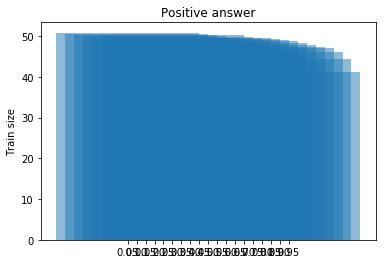

In [9]:
train_size_list, results_for_train_size = read_pickle('pickle/size_train_test_results.pickle')

plt.bar(train_size_list, results_for_train_size, align='center', alpha=0.5)
plt.xticks(train_size_list)
plt.ylabel('Train size')
plt.title('Positive answer')

plt.show()

Now, we will test to build our classifier with the best training set to maximise our results :

In [5]:
best_model = run_test(0.2);
for i in range(0, 500):
    new_model = run_test(0.2);
    if(new_model[0] > best_model[0]):
        best_model = new_model;
        
write_pickle('pickle/best_model.pickle', best_model);

63.75


In [18]:
print(best_model[0])
for genre in best_model[1]:
    print("Error for " + genre + " : " + str(round(best_model[1][genre] / best_model[2][genre] * 100, 2)) + "% - " + str(best_model[1][genre]) + ' on ' + str(best_model[2][genre]))


63.75
Error for Mystery : 100.0% - 21 on 21
Error for Action : 57.14% - 12 on 21
Error for Crime : 31.03% - 9 on 29
Error for Adventure : 66.67% - 6 on 9
Error for Horror : 100.0% - 6 on 6
Error for Romance : 66.67% - 6 on 9
Error for Thriller : 100.0% - 5 on 5
Error for Comedy : 12.9% - 4 on 31
Error for Biography : 100.0% - 3 on 3
Error for Family : 100.0% - 3 on 3
Error for Fantasy : 25.0% - 3 on 12
Error for Animation : 100.0% - 3 on 3
Error for SciFi : 100.0% - 3 on 3


So we finally have a classifier based on the logistic regression algorithm that get 63% of success on our testing dataset. Considering that each TV show have often between 2 and 3 genres and that we have 17 different genres, its an interesting result. However, some genres need more data like SciFi, Animation, Family, Biography, Thriller, etc.